In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import pmdarima as pm
from pmdarima.arima import ARIMA
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# loading Dataset

In [19]:
INPUT_PATH = 'data/labels.parquet'
OUTPUT_PATH = 'data/arima_predict.parquet'

# imports

In [3]:
def load_data(path):
    dataset = pd.read_parquet(path, engine = 'pyarrow') 
    return dataset

In [4]:
rides_df = load_data(INPUT_PATH)

# Preprocessing 

In [5]:
def preprocessing(rides_df):
    loc_ts={}
    demand=[]
    pre_Location=1
    
    for i in range(len(rides_df)):
        
      if rides_df.Location[i]!=pre_Location:
        loc_ts[f'LocationID_{pre_Location}']=demand
        demand=[]
          
      demand.append(rides_df.Demand[i])
      pre_Location = rides_df.Location[i]
        
    loc_ts[f'LocationID_{pre_Location}'] = demand
    loc_labels_df = pd.DataFrame(loc_ts)
    
    return loc_labels_df

In [6]:
loc_labels_df = preprocessing(rides_df)
print(f'loc_labels_df shape : {loc_labels_df.shape}')
loc_labels_df.head()

loc_labels_df shape : (120, 262)


LocationID_1  LocationID_2  LocationID_3  LocationID_4  LocationID_5  \
0          40.0           0.0           0.0         174.0           3.0   
1          31.0           0.0           2.0          32.0           2.0   
2          27.0           0.0           2.0          51.0           2.0   
3           7.0           0.0           1.0          43.0           2.0   
4          15.0           0.0           2.0          42.0           2.0   

   LocationID_6  LocationID_7  LocationID_8  LocationID_9  LocationID_10  ...  \
0           1.0         126.0           1.0           0.0           47.0  ...   
1           3.0          39.0           0.0           2.0           36.0  ...   
2           1.0          48.0           0.0           1.0           53.0  ...   
3           1.0          38.0           0.0           1.0           46.0  ...   
4           5.0          49.0           1.0           3.0           43.0  ...   

   LocationID_256  LocationID_257  LocationID_258  LocationID_259  \
0           125.0             5.0             5.0             1.0   
1            13.0             2.0             4.0             1.0   
2            17.0             2.0             5.0             0.0   
3            17.0             2.0             4.0             5.0   
4            12.0             2.0             3.0             4.0   

   LocationID_260  LocationID_261  LocationID_262  LocationID_263  \
0            48.0           510.0           837.0          1942.0   
1            15.0           432.0           758.0          1328.0   
2            14.0           338.0          1344.0          1746.0   
3            22.0           432.0          1479.0          1967.0   
4            20.0           436.0          1552.0          2035.0   

   LocationID_264  LocationID_265  
0          1176.0           124.0  
1          1110.0            59.0  
2          1249.0            54.0  
3          1294.0            51.0  
4          1393.0            45.0  

[5 rows x 262 columns]

# ARIMA MODEL

## train config 

In [7]:
col = loc_labels_df.columns
train_size_ratio = 0.2

## Split Dataset

In [8]:
def split_data(loc_labels_df, location, train_size_ratio):
    size = int(len(loc_labels_df) * train_size_ratio)
    val_tr = loc_labels_df.loc[0:size, location]
    val_te = loc_labels_df.loc[size:, location]
    return (val_tr, val_te)

In [9]:
def arima_forecast(val_tr, val_te):
    history = [x for x in val_tr]
    predictions = []
    model = pm.arima.auto_arima(
                              history, start_p=1, start_q=1,
                              test='kpss', max_p=8, max_q=8,
                              seasonal=False, m=1,
                              d=None, start_P=0,
                              suppress_warnings=True, trace=True)
    for t in range(len(val_te)):
        best_arima_model_fit = pm.arima.ARIMA(order=model.get_params().get("order")).fit(history)
        output = best_arima_model_fit.predict(n_periods=1)
        yhat = output[0]
        predictions.append(int(yhat))
        obs = val_te.iloc[t]
        history.append(obs)
    
    val_te = val_te.reset_index()
    return (val_te.iloc[:,1], predictions,
          history, best_arima_model_fit.fittedvalues())


train and predict for all locationIDs


In [10]:
def rmse(val_te, predictions):
  rmse = sqrt(mean_squared_error(val_te, predictions))
  return rmse

In [11]:
def mape(val_te, predictions):
  mape = mean_absolute_percentage_error(val_te, predictions)
  return mape

In [12]:
def predict_all_location(loc_labels_df, col, train_size_ratio):
    all_loc_rmse = []
    all_loc_mape = []
    val_predicted = {}
    val_test = {}
    val_fit = {}
    for loc in col:
        print('\n\nlocation: %s' %(loc))
        val_tr, val_te = split_data (loc_labels_df, loc, train_size_ratio)
        result = arima_forecast(val_tr, val_te)
        val_rmse = rmse (result[0], result[1])
        val_mape = mape (result[0], result[1])
        all_loc_rmse.append(val_rmse)
        all_loc_mape.append(val_mape)
        val_test[loc] = result[0]
        val_predicted[loc] = result[1]
        val_fit[loc] = result[3]
    
    val_test = pd.DataFrame(val_test)
    val_fit = pd.DataFrame(val_fit)
    val_predicted = pd.DataFrame(val_predicted)
    return (val_test, val_predicted, val_fit, all_loc_rmse, all_loc_mape)

In [13]:
val_test, val_predicted, val_fit, all_loc_rmse, all_loc_mape = predict_all_location(loc_labels_df, col, train_size_ratio)



location: LocationID_1
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=180.862, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=212.878, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=181.733, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=201.869, Time=0.01 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=182.357, Time=0.03 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=182.304, Time=0.06 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=180.359, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=182.357, Time=0.03 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=184.298, Time=0.08 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=179.742, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=178.891, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=183.187, Time=0.00 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=180.199, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] in

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pmdarima/arima/auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximu



location: LocationID_3
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=90.023, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=101.711, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=92.186, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=96.657, Time=0.01 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=91.257, Time=0.12 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=96.001, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=93.068, Time=0.01 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=93.493, Time=0.10 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=87.133, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=85.139, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=83.671, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=85.192, Time=0.02 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.513 seconds


location: LocationID_4


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "




location: LocationID_5
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=80.751, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=106.843, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=83.848, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=97.053, Time=0.01 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=82.629, Time=0.03 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=82.660, Time=0.03 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=93.269, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=82.338, Time=0.02 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=84.556, Time=0.12 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=79.301, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=78.740, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=79.304, Time=0.01 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=79.525, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=77.741, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept  

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.wa



location: LocationID_9
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=92.257, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=97.963, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=90.296, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=90.989, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=92.293, Time=0.01 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=93.315, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=85.378, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=84.504, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=84.389, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=85.586, Time=0.03 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=85.238, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0] intercept
Total fit time: 0.284 seconds


location: LocationID_10
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_ret



location: LocationID_14
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=128.285, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=177.075, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=127.298, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=158.218, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=128.186, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=130.064, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=122.123, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=126.458, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=124.099, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=124.113, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=123.638, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=126.038, Time=0.08 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.417 seconds


location: LocationID_15
Performing stepwise search to minimize aic
 ARIM

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.wa



location: LocationID_16
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=108.585, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=102.166, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=105.217, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=101.265, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=98.216, Time=0.04 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=99.274, Time=0.05 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=95.197, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=97.017, Time=0.08 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=0.18 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=91.434, Time=0.11 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=89.4

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pmdarima/arima/auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximu



location: LocationID_28
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=179.400, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=222.910, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=177.403, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=201.210, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=179.402, Time=0.01 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=180.775, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=169.258, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=170.043, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=166.834, Time=0.05 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=168.615, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=166.406, Time=0.12 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=168.512, Time=0.04 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=167.959, Time=0.16 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=167.946, Time=0.17 sec
 ARIMA(1,0,2)(0,0,0)[

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive para



location: LocationID_29
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=113.902, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=130.411, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=115.551, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=118.120, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=118.147, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=113.106, Time=0.07 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=119.242, Time=0.03 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=113.739, Time=0.09 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=113.115, Time=0.11 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=117.630, Time=0.04 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=0.25 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=110.414, Time=0.08 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=108.430, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=107.617, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] i

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.wa



location: LocationID_31
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=58.598, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=54.598, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=56.598, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=56.598, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=50.599, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=50.955, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.284 seconds


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.wa



location: LocationID_32
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=141.371, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=130.128, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=136.503, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=127.436, Time=0.01 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=128.081, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=117.149, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=115.267, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=113.538, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=115.215, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.596 seconds


location: LocationID_33

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization



location: LocationID_44
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=93.834, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=104.408, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=91.834, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=96.938, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=93.834, Time=0.01 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=95.416, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=87.487, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=87.774, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=87.583, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=89.126, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=87.267, Time=0.02 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=82.986, Time=0.03 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AI

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.wa



location: LocationID_47
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=112.159, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=108.861, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=110.284, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=100.948, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=102.688, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=100.809, Time=0.03 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=99.612, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=102.045, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=99.9

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.wa



location: LocationID_58
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=9.804, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=4.887, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=4.165, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=4.733, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=4.615, Time=0.02 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0]          
Total fit time: 0.350 seconds


location: LocationID_59
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-527.699, Time=0.01 sec
Total fit time: 0.013 seconds


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pmdarima/arima/auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximu



location: LocationID_60
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=109.861, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=116.016, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=108.101, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=111.828, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=109.882, Time=0.01 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=111.809, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=103.249, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=102.743, Time=0.00 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=103.082, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=105.047, Time=0.02 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.133 seconds


location: LocationID_61
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=184.103, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=216.371, Time=0.00 sec
 ARIM

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.wa



location: LocationID_74
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=266.083, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=338.963, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=274.016, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=314.288, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=277.064, Time=0.09 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=267.609, Time=0.08 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=301.546, Time=0.07 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=272.990, Time=0.03 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=260.871, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=258.635, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=257.146, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=258.808, Time=0.02 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.533 seconds


location: L

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pmdarima/arima/auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximu



location: LocationID_85
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=128.099, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=114.306, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=121.059, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=112.421, Time=0.01 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=112.787, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=103.741, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=101.876, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=100.051, Time=0.00 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=101.843, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.447 seconds


location: LocationID_86

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check



location: LocationID_89
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=188.679, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=147.345, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=174.528, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=144.343, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=145.907, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=135.022, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=133.030, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=131.257, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=133.046, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=135.029, Time=0.06 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.594 seconds


location: LocationI

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.wa



location: LocationID_100
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=353.323, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=442.148, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=351.536, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=353.320, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=355.516, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=345.908, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=353.081, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=343.897, Time=0.05 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=342.558, Time=0.10 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=343.880, Time=0.11 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=344.195, Time=0.12 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=347.596, Time=0.10 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=345.814, Time=0.14 sec
 ARIMA(3,0,0)(0,0,0)[0] 

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pmdarima/arima/auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximu



location: LocationID_106
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=142.010, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=137.792, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=138.450, Time=0.01 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=127.597, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=126.933, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.366 seconds


location: LocationID_107
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=387.832, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=457.951, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.wa



location: LocationID_111
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-1.541, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=9.804, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=4.887, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-3.446, Time=0.04 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-1.573, Time=0.06 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=0.169, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-2.447, Time=0.07 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 0.357 seconds


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "




location: LocationID_112
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=222.321, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=232.162, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=221.192, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=223.118, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=215.641, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=214.029, Time=0.00 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.266 seconds


location: LocationID_113
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=358.477, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=431.508, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "




location: LocationID_115
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=37.959, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=37.269, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=36.437, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=35.974, Time=0.02 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=37.962, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=36.241, Time=0.03 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 0.249 seconds


location: LocationID_116
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=289.363, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=227.026, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=269.699, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=225.307, Time=0.02 sec
 ARIMA(3,0,0)(0,0

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.wa



location: LocationID_119
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=142.136, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=125.778, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=135.452, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=122.229, Time=0.01 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=121.796, Time=0.02 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=123.527, Time=0.03 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=115.950, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=114.047, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=112.117, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=110.139, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.wa



location: LocationID_121
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=118.572, Time=0.31 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=143.182, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=126.035, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=136.386, Time=0.10 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=120.486, Time=0.05 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=120.515, Time=0.05 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=129.906, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=120.878, Time=0.02 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=122.393, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=116.118, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=114.460, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=112.491, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=114.445, Time=0.02 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.712 seconds


locati

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.wa



location: LocationID_123
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=118.877, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=124.933, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=116.886, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=118.620, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=118.885, Time=0.01 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=120.780, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=109.179, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=107.476, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=108.564, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=110.052, Time=0.05 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.186 seconds


location: LocationID_124
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=167.300, Time=0.00 sec
 ARIMA(

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "




location: LocationID_129
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=189.756, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=224.390, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=191.158, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=207.988, Time=0.01 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=194.654, Time=0.03 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=191.377, Time=0.04 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=203.089, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=193.068, Time=0.01 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=185.079, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=183.871, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=182.021, Time=0.01 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.336 seconds


location: Loca

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.wa



location: LocationID_134
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=190.748, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=153.039, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=171.510, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=154.416, Time=0.01 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=156.647, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=142.750, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=141.722, Time=0.00 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=141.288, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=141.973, Time=0.03 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0] intercept
Total fit time: 0.400 seconds


location: LocationID_135
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "




location: LocationID_142
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=390.548, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=477.467, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=388.726, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=390.627, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=392.388, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=382.827, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=388.965, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=379.994, Time=0.06 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=381.674, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=382.795, Time=0.12 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=382.063, Time=0.05 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=383.573, Time=0.17 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0] intercept
Total fit time: 0.706 seconds


location: 

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "




location: LocationID_145
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=213.140, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=290.824, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=222.430, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=271.187, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=214.993, Time=0.06 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=215.027, Time=0.06 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=207.432, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=205.438, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=203.523, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=205.425, Time=0.02 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.447 seconds


location: Location

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "




location: LocationID_147
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=112.162, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=106.897, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=110.160, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=105.907, Time=0.01 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=107.167, Time=0.01 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=101.950, Time=0.07 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=101.230, Time=0.05 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=104.787, Time=0.02 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=103.062, Time=0.07 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=101.792, Time=0.13 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=104.886, Time=0.03 sec
 ARIMA(5,0,2)(0,0,0)[0]         

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check



location: LocationID_149
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=102.694, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=95.327, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=100.740, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=96.016, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=93.568, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=94.444, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=91.715, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=89.901, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=91.740, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=92.801, Time=0.05 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.487 seconds


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "




location: LocationID_150
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=93.478, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=97.592, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=95.668, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=97.103, Time=0.01 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=95.288, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=95.106, Time=0.04 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=97.692, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=95.249, Time=0.01 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=91.917, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=89.917, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=87.917, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=89.917, Time=0.01 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.315 seconds


location: LocationID_1

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.wa



location: LocationID_152
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=283.176, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=222.138, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=263.851, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=222.660, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=224.108, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=210.001, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=209.939, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=210.027, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=211.866, Time=0.04 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.311 seconds


location: LocationID_153
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=85.314, Time=0.00 sec
 ARIMA(1,0,0

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.wa



location: LocationID_154
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=80.634, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=80.167, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=80.838, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=81.786, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=75.656, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=73.675, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=75.651, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=76.118, Time=0.06 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.355 seconds


location: LocationID_155
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=151.893, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.wa



location: LocationID_157
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=176.605, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=141.104, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=163.040, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=133.454, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=133.461, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=118.375, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=116.671, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=117.291, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=120.656, Time=0.10 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] int

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "




location: LocationID_163
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=383.533, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=469.558, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=382.832, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=383.620, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=385.492, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=378.785, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=387.992, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=373.398, Time=0.08 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=374.033, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=376.551, Time=0.11 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=377.750, Time=0.06 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=375.262, Time=0.14 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0] intercept
Total fit time: 0.674 seconds


location: 

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pmdarima/arima/_auto_solvers.py:524: ModelFitWarning: Error fitting  ARIMA(2,0,2)(0,0,0)[0]           (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pmdarima/arima/_auto_solvers.py", line 508, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pmdarima/arima/arima.py", line 603, in fit
    self._fit(y, X, **fit_args)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pmdarima/arima/arima.py", line 524, in _fit
    fit, self.arima_res_ = _fit_wrapper()
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pmdarima/arima/arima.py", line 510, in _fit_wrapper
    fitted = arima.fit(
  Fil

 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=nan sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=364.328, Time=0.15 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=357.417, Time=0.08 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=355.267, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=353.477, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=364.378, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=355.482, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=356.692, Time=0.01 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0] intercept
Total fit time: 1.217 seconds


location: LocationID_165
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=153.056, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=139.244, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]  

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "




location: LocationID_168
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=197.810, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=173.450, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=188.071, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=166.963, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=163.832, Time=0.02 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=165.830, Time=0.04 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=165.828, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=161.605, Time=0.05 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=161.624, Time=0.07 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=165.012, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=157.292, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=155.286, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] inte

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.wa



location: LocationID_173
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=89.208, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=103.834, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=95.949, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=100.534, Time=0.01 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=91.164, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=91.163, Time=0.03 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=98.203, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=93.979, Time=0.01 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=86.708, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=84.709, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=82.751, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=84.709, Time=0.02 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.340 seconds


location: LocationID

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pmdarima/arima/auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximu



location: LocationID_177
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=172.542, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=142.011, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=159.611, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=134.024, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=133.826, Time=0.02 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=135.772, Time=0.02 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.18 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=123.498, Time=0.08 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=121.645, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=119.648, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=119.038, Time=0.00 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "




location: LocationID_179
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=175.639, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=218.948, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=178.714, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=204.513, Time=0.01 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=176.963, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=177.050, Time=0.05 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=177.928, Time=0.03 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=171.211, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=169.220, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=167.811, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=169.223, Time=0.03 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.502 seconds


location: Loca

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.wa



location: LocationID_184
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-3.525, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-7.525, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-5.525, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-5.525, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-6.546, Time=0.01 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.066 seconds


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.wa



location: LocationID_185
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=116.374, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=130.210, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=114.919, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=122.195, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=116.399, Time=0.01 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=109.338, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=109.140, Time=0.00 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=109.247, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=111.172, Time=0.02 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.190 seconds


location: LocationID_186
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=343.853, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=347.962, Time=0.00 sec
 ARIMA(

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.wa



location: LocationID_188
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=197.496, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=155.877, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=183.429, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=151.488, Time=0.01 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=153.393, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=152.761, Time=0.03 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=154.456, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=142.777, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=141.075, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=139.166, Time=0.00 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=141.093, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=143.055, Time=0.05 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.333 seconds


location: 

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "




location: LocationID_195
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=173.090, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=174.970, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=176.109, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=176.544, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=173.208, Time=0.03 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=173.452, Time=0.04 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=172.612, Time=0.06 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=169.292, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=170.095, Time=0.03 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=171.200, Time=0.09 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=170.742, Time=0.05 sec
 ARIMA(1,0,3)(0,0,0)[0] intercep

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.wa



location: LocationID_200
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=129.904, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=119.845, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=126.123, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=118.040, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=119.583, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=119.093, Time=0.04 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=121.087, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=111.031, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=109.036, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=107.037, Time=0.00 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=109.036, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=110.587, Time=0.03 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.433 seconds


location: 

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.wa



location: LocationID_205
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=181.620, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=155.888, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=164.654, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=157.133, Time=0.01 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=159.023, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=145.968, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=144.879, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=144.549, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=144.916, Time=0.03 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=144.295, Time=0.03 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=146.261, Time=0.05 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=146.248, Time=0.04 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=148.261, Time=0.05 sec
 ARIMA(0,0,2)(0,0,0)[0] 

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "




location: LocationID_207
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=158.730, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=179.429, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=157.253, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=165.219, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=158.912, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=160.697, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=152.466, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=154.372, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=148.523, Time=0.06 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=148.722, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=148.211, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=152.172, Time=0.03 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=150.104, Time=0.11 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(1,0,2)(0,0,0)[0] 

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible st



location: LocationID_208
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=108.166, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=126.271, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=119.527, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=124.432, Time=0.01 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=108.242, Time=0.03 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=108.779, Time=0.04 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=119.112, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=110.212, Time=0.01 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=109.776, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=102.836, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=101.783, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=101.308, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=101.348, Time=0.02 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.297 seconds


locati

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "




location: LocationID_212
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=104.123, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=91.770, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=97.608, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=88.578, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=88.082, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=90.082, Time=0.03 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=0.16 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.17 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=81.528, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=79.529, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=77.532, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=76.081, Time=0.00 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=77.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "




location: LocationID_213
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=173.130, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=151.398, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=163.090, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=147.524, Time=0.01 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=146.662, Time=0.02 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=148.349, Time=0.03 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=147.679, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=149.669, Time=0.05 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=139.298, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=137.334, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=135.338, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=133.438, Time=0.00 sec
 ARIMA(0,0,1)(0,0,0)[0] inte

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.wa



location: LocationID_215
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=240.287, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=174.456, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=173.298, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=158.542, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=157.885, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=155.893, Time=0.00 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=157.877, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.542 seconds


location: LocationID_216
Perfo

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to conver



location: LocationID_220
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=147.840, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=123.937, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=136.036, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=125.101, Time=0.01 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=114.744, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=113.280, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=114.549, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=116.532, Time=0.03 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.270 seconds


location: LocationID_221
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=62.451, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=58.451, Time=0.01 sec
 ARIMA(1,0,0)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.wa



location: LocationID_222
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=125.158, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=157.944, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=130.194, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=126.329, Time=0.04 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=130.639, Time=0.02 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0]          
Total fit time: 0.352 seconds


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.wa



location: LocationID_223
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=162.381, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=221.485, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=168.266, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=202.869, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=163.986, Time=0.03 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=164.160, Time=0.03 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=191.215, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=162.729, Time=0.02 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=165.842, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=159.319, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=157.849, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=155.987, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=157.766, Time=0.03 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.335 seconds


locati

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "




location: LocationID_231
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=359.565, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=429.953, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=357.663, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=359.607, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=361.440, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=350.297, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=355.661, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=347.071, Time=0.08 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=347.589, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=350.291, Time=0.11 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=349.895, Time=0.04 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=349.575, Time=0.10 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0] intercept
Total fit time: 0.587 seconds


location: 

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "




location: LocationID_241
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=102.553, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=93.927, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=100.740, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=88.552, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=87.920, Time=0.04 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=89.772, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=86.190, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=86.907, Time=0.01 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=88.081, Time=0.03 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=88.06

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.wa



location: LocationID_246
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=372.012, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=438.342, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=370.901, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=415.719, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=372.098, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=372.450, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=365.213, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=376.149, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=367.195, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=367.190, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=369.346, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=369.135, Time=0.08 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.366 seconds


location: LocationID_247
Performing stepwise search to minimize aic
 AR

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.wa



location: LocationID_252
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=69.113, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=78.325, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=71.029, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=75.279, Time=0.01 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=71.056, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=71.075, Time=0.03 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=71.770, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=69.980, Time=0.01 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=67.222, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=65.797, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=64.650, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=65.542, Time=0.01 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.329 seconds


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.wa



location: LocationID_253
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=44.461, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=44.690, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=44.789, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=36.820, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=38.713, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=38.632, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.227 seconds


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.wa



location: LocationID_254
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=127.292, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=156.956, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=127.026, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=143.446, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=128.380, Time=0.01 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=126.755, Time=0.03 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=128.215, Time=0.06 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=126.563, Time=0.04 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=137.178, Time=0.01 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=128.383, Time=0.04 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec

Best model:  ARIMA(1,0,2)(0,0,0)[0]

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "




location: LocationID_255
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=280.709, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=271.492, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=272.313, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=268.242, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=268.919, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=264.229, Time=0.04 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=266.227, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=265.488, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.03 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=266.076, Time=0.14 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0] intercept
Total fit time: 0.529 seconds


location: LocationID_2

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.wa



location: LocationID_261
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=374.821, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=306.687, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=307.933, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=308.847, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=291.375, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=289.719, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=289.123, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=288.594, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=290.645, Time=0.08 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=288.698, Time=0.02 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "




location: LocationID_262
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=354.608, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=435.889, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=354.004, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=355.192, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=356.356, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=348.803, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=356.281, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=341.950, Time=0.05 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=343.254, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=348.158, Time=0.10 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=345.839, Time=0.05 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=344.818, Time=0.13 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0] intercept
Total fit time: 0.668 seconds


location: 

## evaluation

### plots

In [14]:
def prediction_visualization(val_test, val_predicted, val_fit, all_loc_rmse, all_loc_mape, loc_labels_df):
    
    loc = loc_labels_df.columns
    x = np.arange(0,len(col)+1, 5)
    plt.figure(figsize = (28,18))
    plt.subplot(2,1,1)
    plt.plot(all_loc_rmse, color = 'red')
    plt.ylabel('rmse measures',fontsize=20)
    plt.xticks(x, col[x], rotation=45)
    plt.subplot(2,1,2)
    plt.plot(all_loc_mape)
    plt.ylabel('mape measures',fontsize=20)
    plt.xticks(x, col[x], rotation=45)
    plt.show()
    

    num_fig = 260
    plt.figure(figsize = (20,18))
    for i in range(num_fig):
        plt.subplot(26, 10, i+1)
        plt.plot(val_test.loc[:,col[i]], color='red')
        plt.plot(val_predicted.loc[:,col[i]], color='green')
        plt.title('%s'%col[i])
    plt.suptitle('predicted vs acual value',y=0.92,fontsize=20)
    plt.show()


    num_fig = 260
    plt.figure(figsize = (20,18))
    for i in range(num_fig):
        plt.subplot(26,10,i+1)
        plt.plot(loc_labels_df.loc[:60,col[i]], color = 'red')
        plt.plot(val_fit.loc[:60,col[i]], color = 'green')
        plt.title('%s'%col[i])
    plt.suptitle('fitted vs acual value',y=0.92,fontsize=20)
    plt.show()

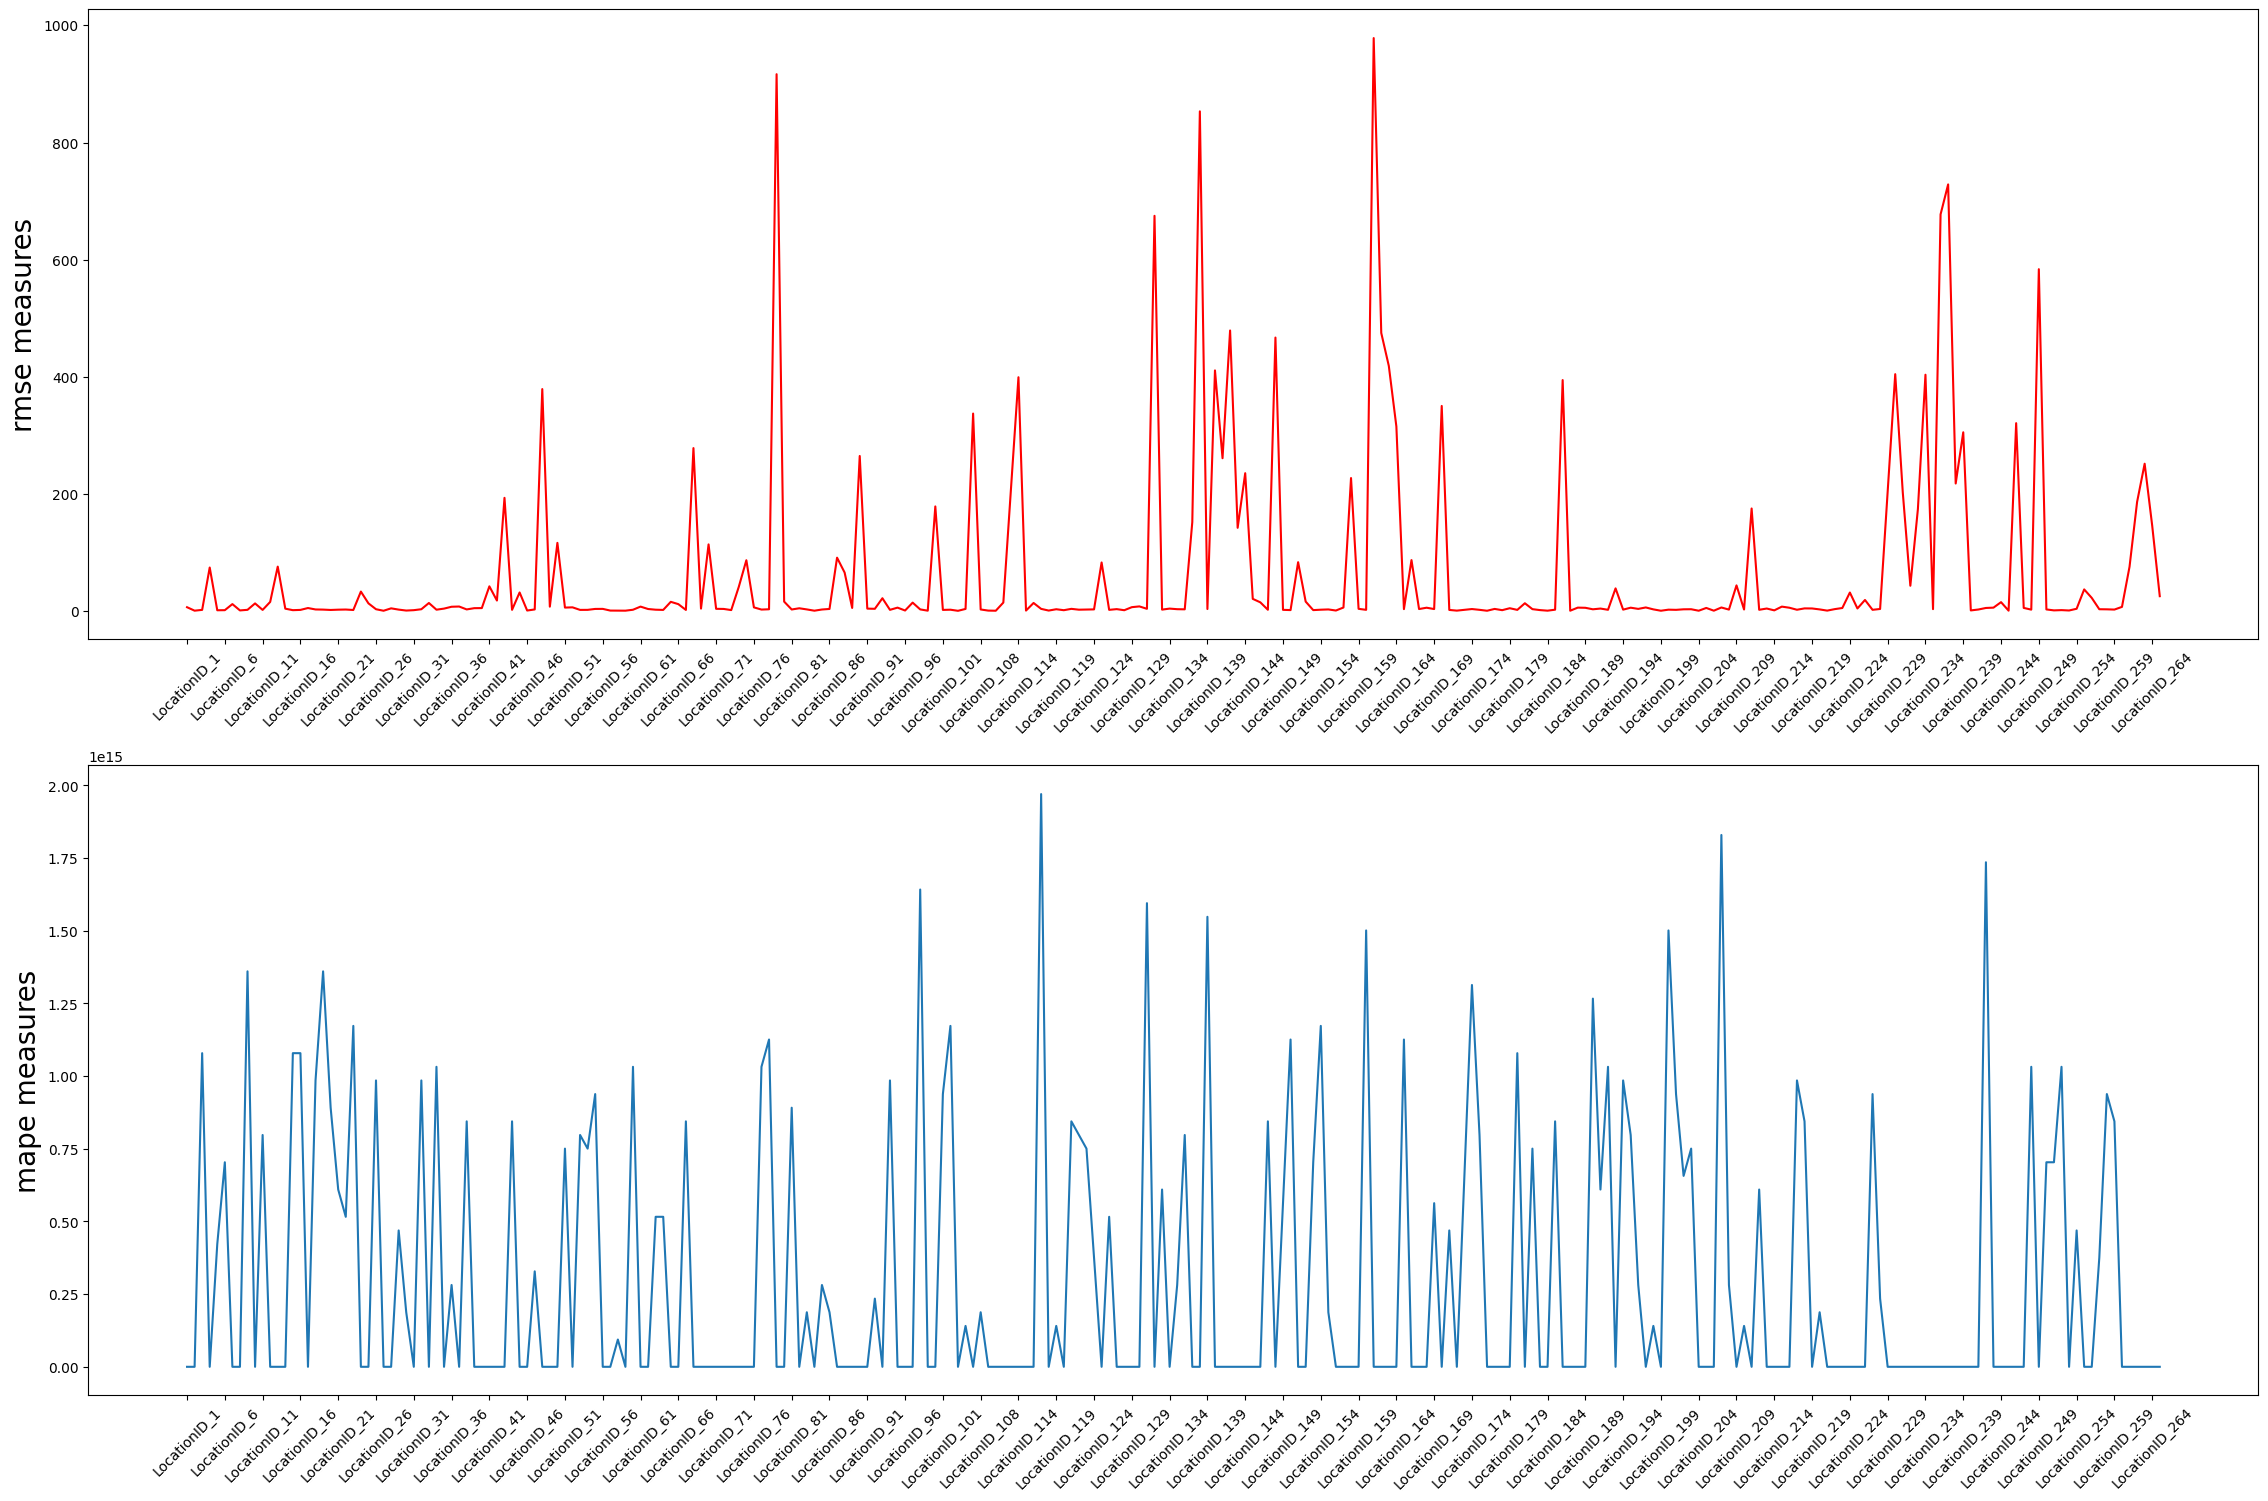

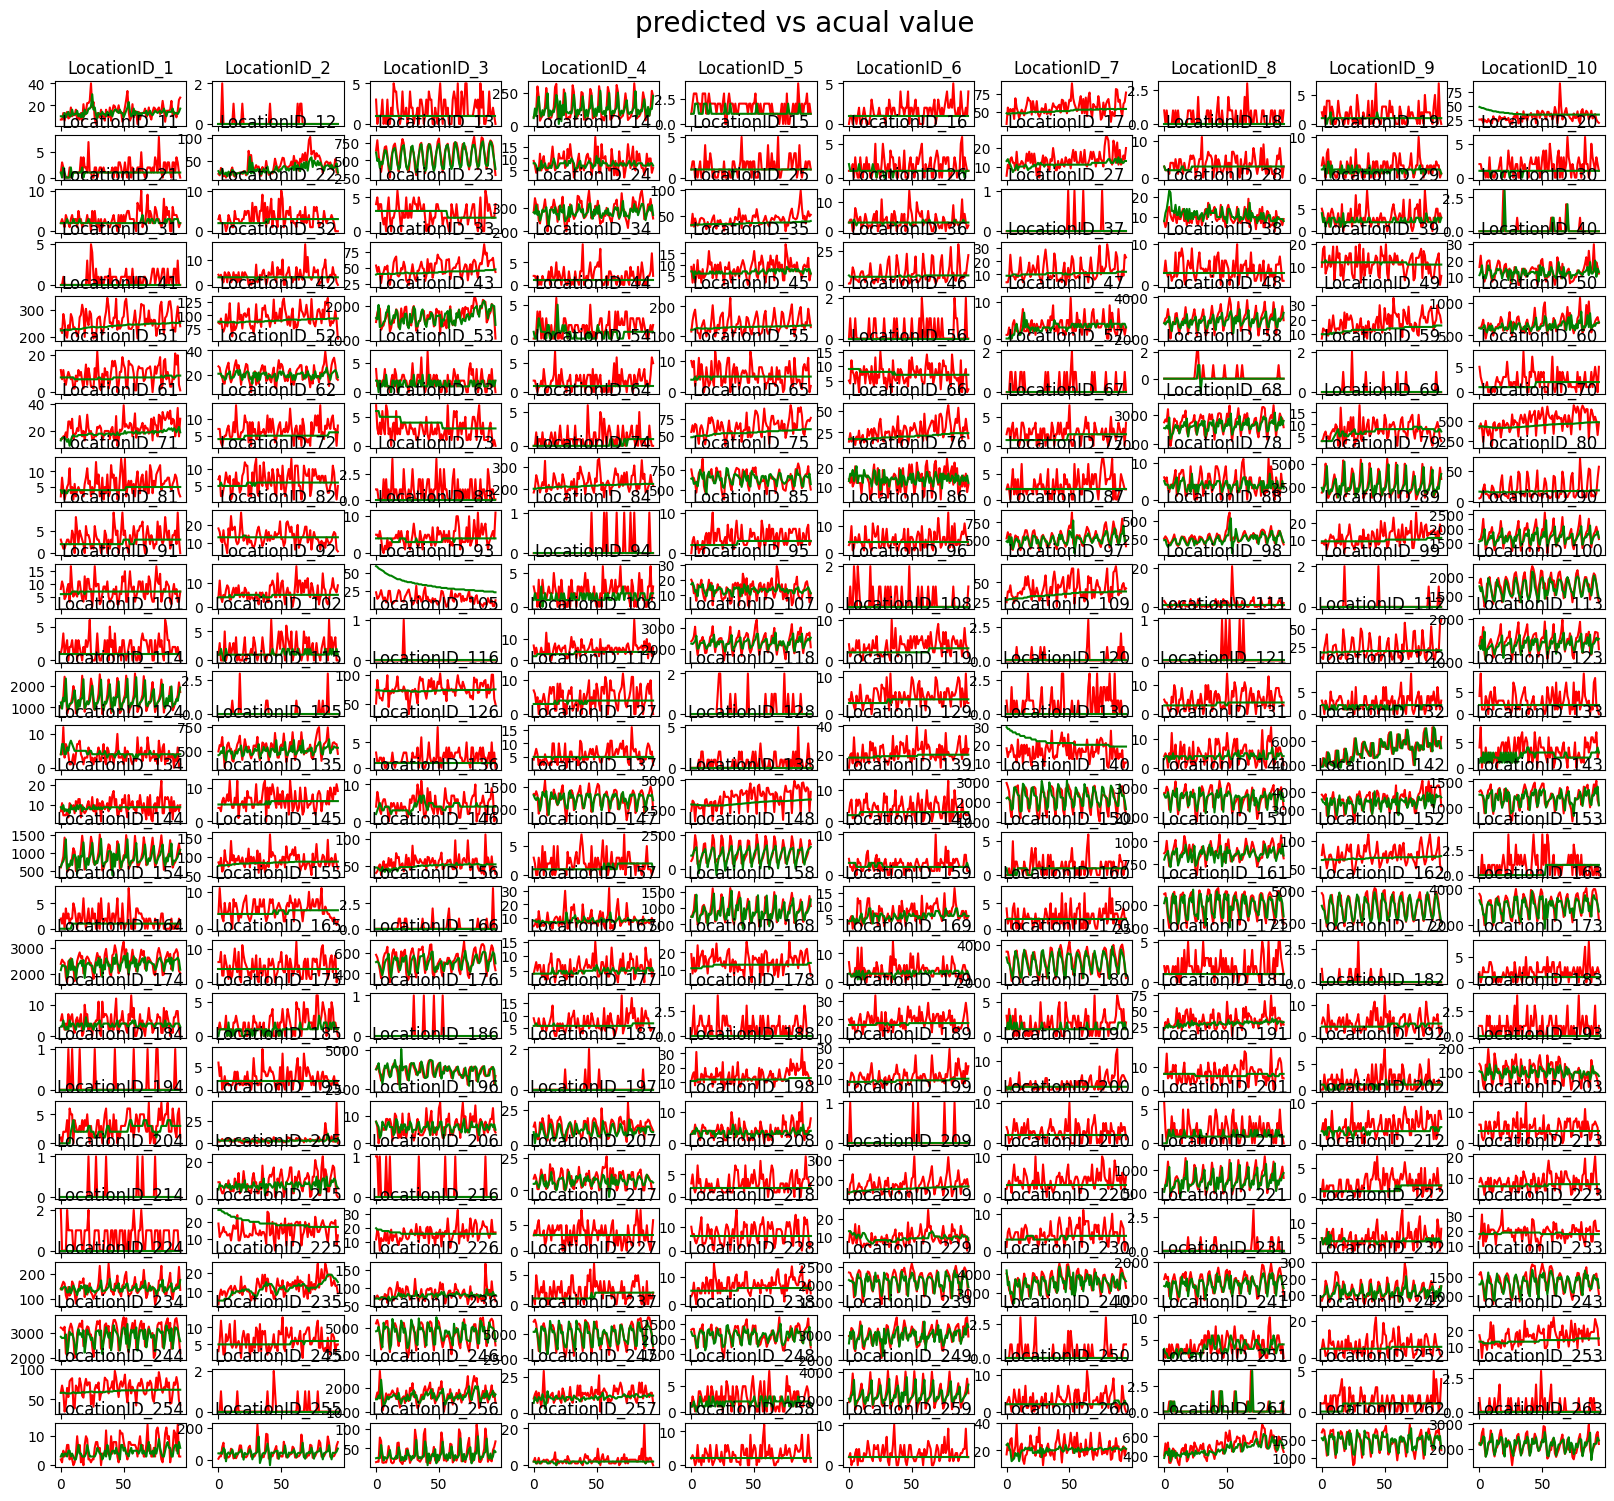

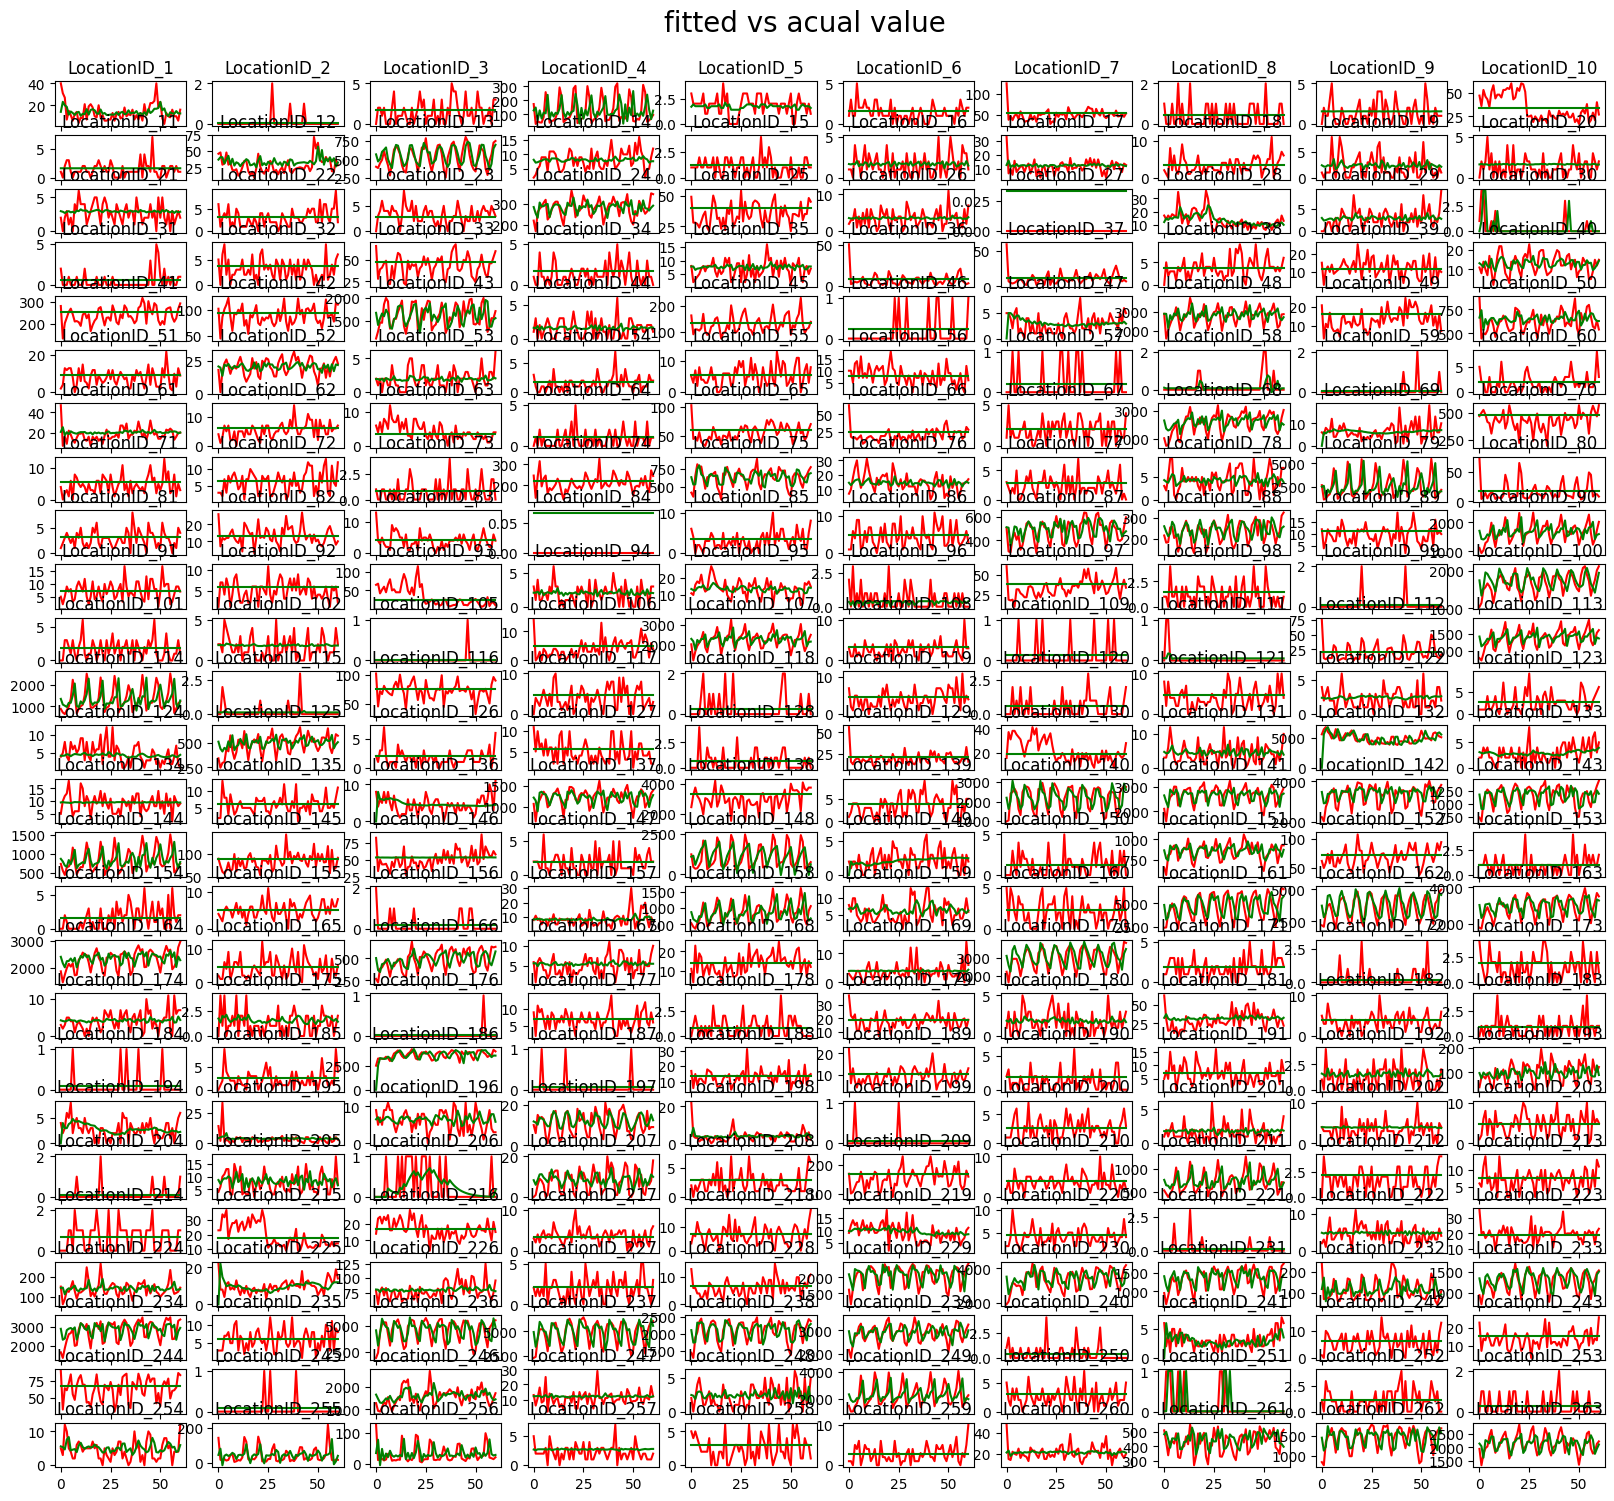

In [15]:
prediction_visualization(val_test, val_predicted, val_fit, all_loc_rmse, all_loc_mape, loc_labels_df)

In [3]:
def minmax_error(val_predicted, val_test):
    error = val_predicted-val_test
    min_max_error = pd.concat([error.abs().min(axis=0),error.abs().max(axis=0)], axis=1,sort=False)
    min_max_error.columns = ['min', 'max']
    
    return min_max_error

In [ ]:
min_max_error = minmax_error(val_predicted, val_test)
min_max_error.head()

# Save

In [20]:
def save_val_predicted(dataset, path):
    labels_df = dataset.to_parquet(path, index=False)

In [21]:
save_val_predicted(val_predicted, OUTPUT_PATH)